In [2]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import json
import yaml

In [18]:
plt.style.use(['science', 'ieee'])

# Analyse server data: Throughput and CPU Usage

## A. Throughput analysis

In [4]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"
    with open(filename) as file:
        test_config = file.read().strip()
    return test_config

In [96]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

In [97]:
res_dirs = [(e, reslv_res_name(e)) for e in os.listdir("../") if e.startswith("results-")]

In [98]:
list(enumerate(res_dirs))

[(0, ('results-d5b32a17', 'irqbalance-rss')),
 (1, ('results-bec7557a', 'irqbalance')),
 (2, ('results-5d846eb1', 'rss')),
 (3, ('results-be8e6425', 'irqbalance-rss__1g')),
 (4, ('results-6e9096e4', 'default')),
 (5, ('results-6eedc9cd', 'irqbalance__1g')),
 (6, ('results-b6c534ca', 'default__1g')),
 (7, ('results-403ccd76', 'rss__1g'))]

In [99]:
res_dir = res_dirs[2][0]

In [100]:
throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")

In [101]:
throughput_csv['client'] *= 10
throughput_csv['rxkB/s'] *= 8e-6
throughput_csv['txkB/s'] *= 8e-6

throughput_csv['rxpck/s'] *= 1e-6
throughput_csv['txpck/s'] *= 1e-6

throughput_csv['expected'] = throughput_csv['client'] * 1

In [102]:
throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']

In [103]:
net_wg = average_data(throughput_wg)
net_phy = average_data(throughput_phy)

In [104]:
net_wg_18 = net_wg[net_wg.cpu == 18]
net_wg_36 = net_wg[net_wg.cpu == 36]

net_phy_18 = net_phy[net_phy.cpu == 18]
net_phy_36 = net_phy[net_phy.cpu == 36]

<AxesSubplot: xlabel='Number of clients', ylabel='Goodput'>

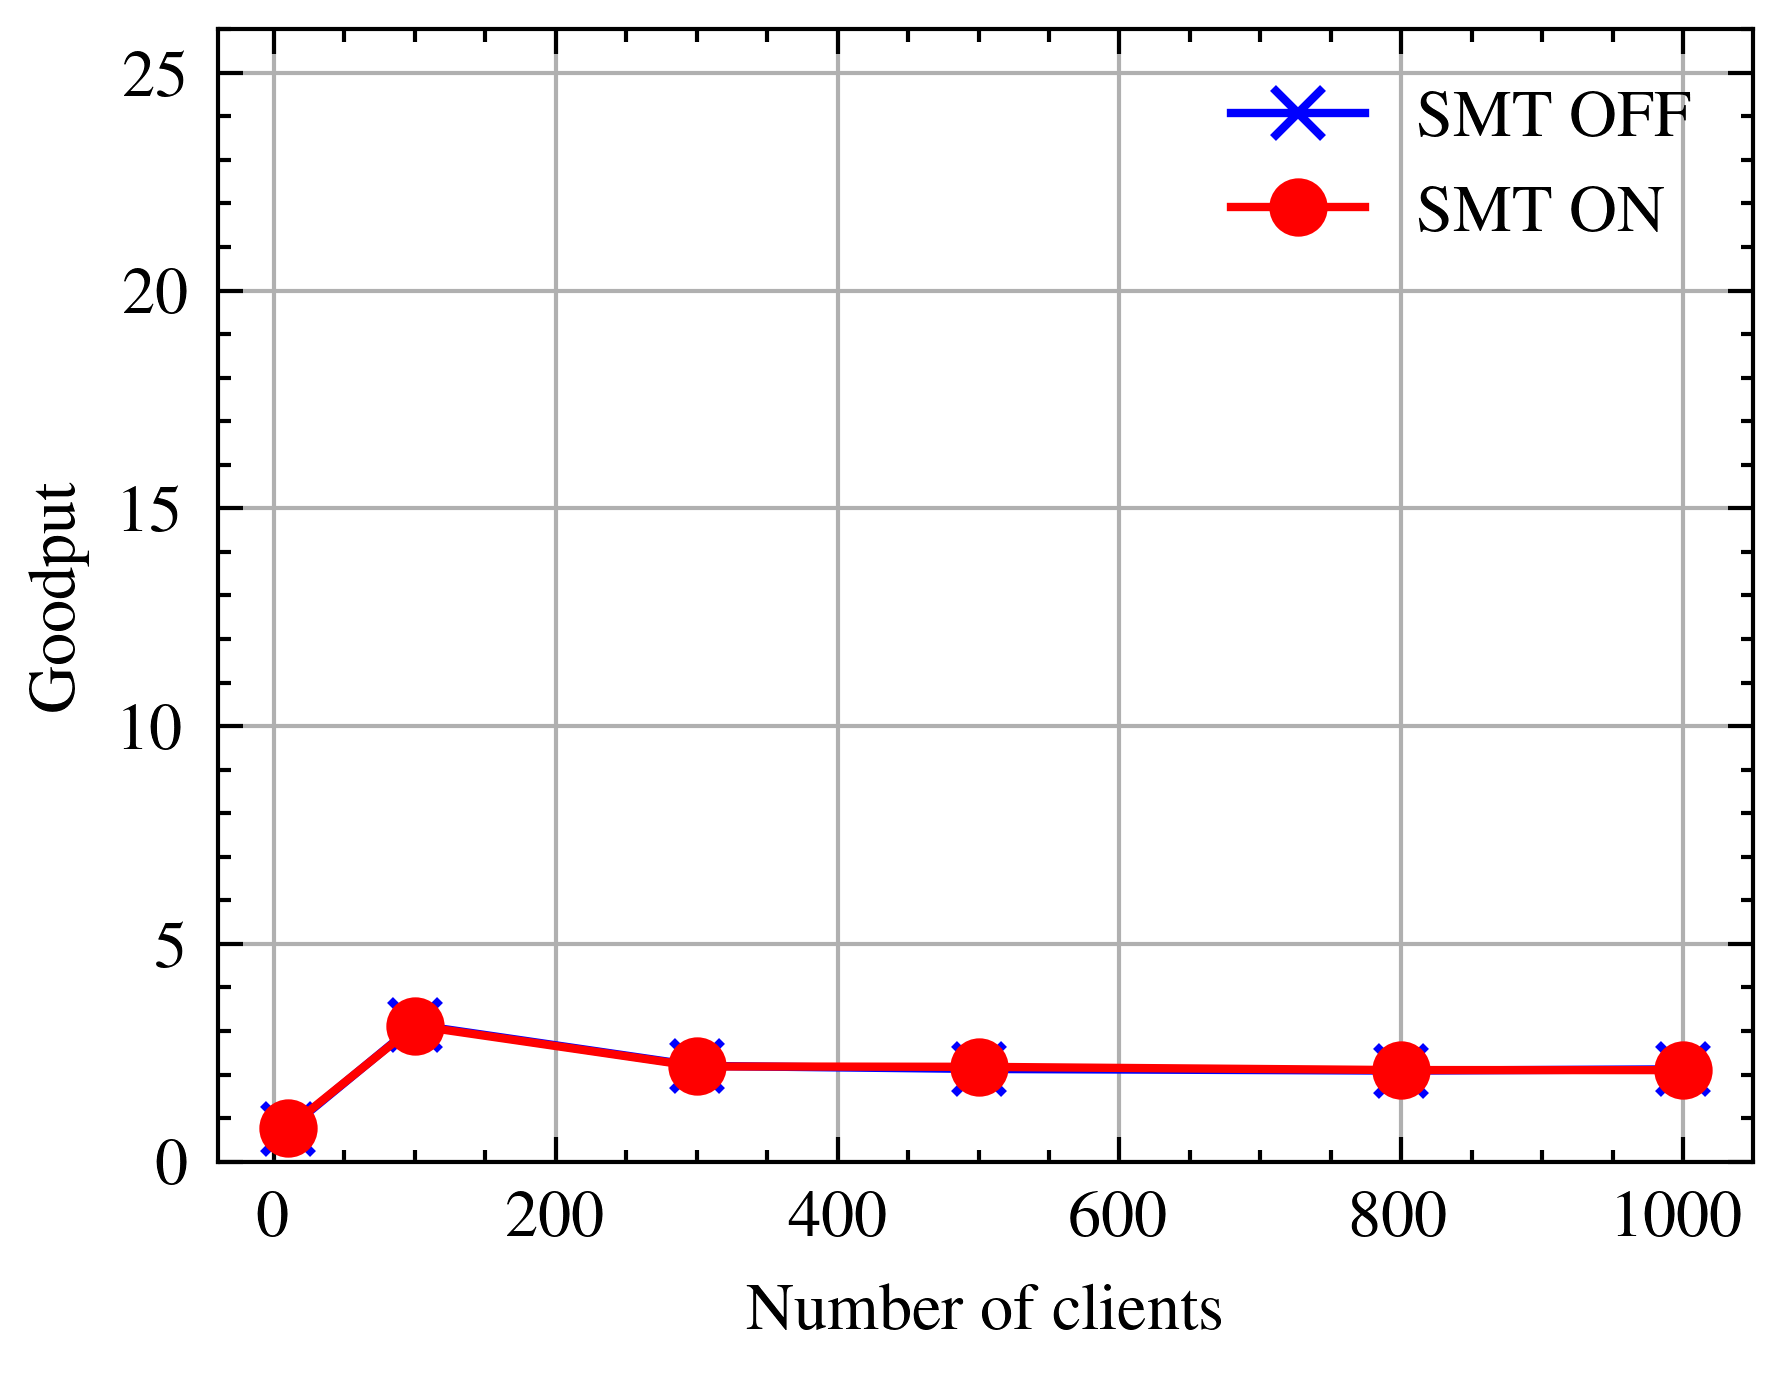

In [105]:
ax = net_wg_18.plot(
    x='client', y='rxkB/s', 
    xlabel='Number of clients', ylabel='Goodput',
    label='SMT OFF', 
    c='blue', style='-', marker='x',)
net_wg_36.plot(ax=ax, 
    x='client', y='rxkB/s', 
    xlabel='Number of clients', ylabel='Goodput',
    label="SMT ON",
    c='red', style='-', marker='o', ylim=[0, 26],
    grid=True)
# net_phy_18.plot(ax=ax,
#     x='client', y='rxkB/s', 
#     xlabel='Number of clients', ylabel='Goodput',
#     label='SMT OFF (Phy)', 
#     c='black', style='--', marker='x',)
# net_phy_36.plot(ax=ax, 
#     x='client', y='rxkB/s', 
#     xlabel='Number of clients', ylabel='Goodput',
#     label="SMT ON (Phy)",
#     c='gray', style='--', marker='o',
#     grid=True)

In [106]:
df_t = []
for i in range(1, 11):
    latency_csv = pd.read_csv(
        f"../{res_dir}/summary/clients/latency-{i}.csv",
        names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
        skiprows=1
    )
    latency_df = average_data(latency_csv, keep=['cpu', 'client'])
    latency_df['client'] *= 10
    latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
    latency_df['node'] = i
    df_t.append(latency_df)
df = pd.concat(df_t, axis=0)

In [107]:
latency_df = df.groupby(['cpu', 'client']).mean().reset_index()

In [108]:
latency_df_18 = latency_df[latency_df.cpu == 18]
latency_df_36 = latency_df[latency_df.cpu == 36]

<AxesSubplot: xlabel='Number of clients', ylabel='Mean Latency (in ms)'>

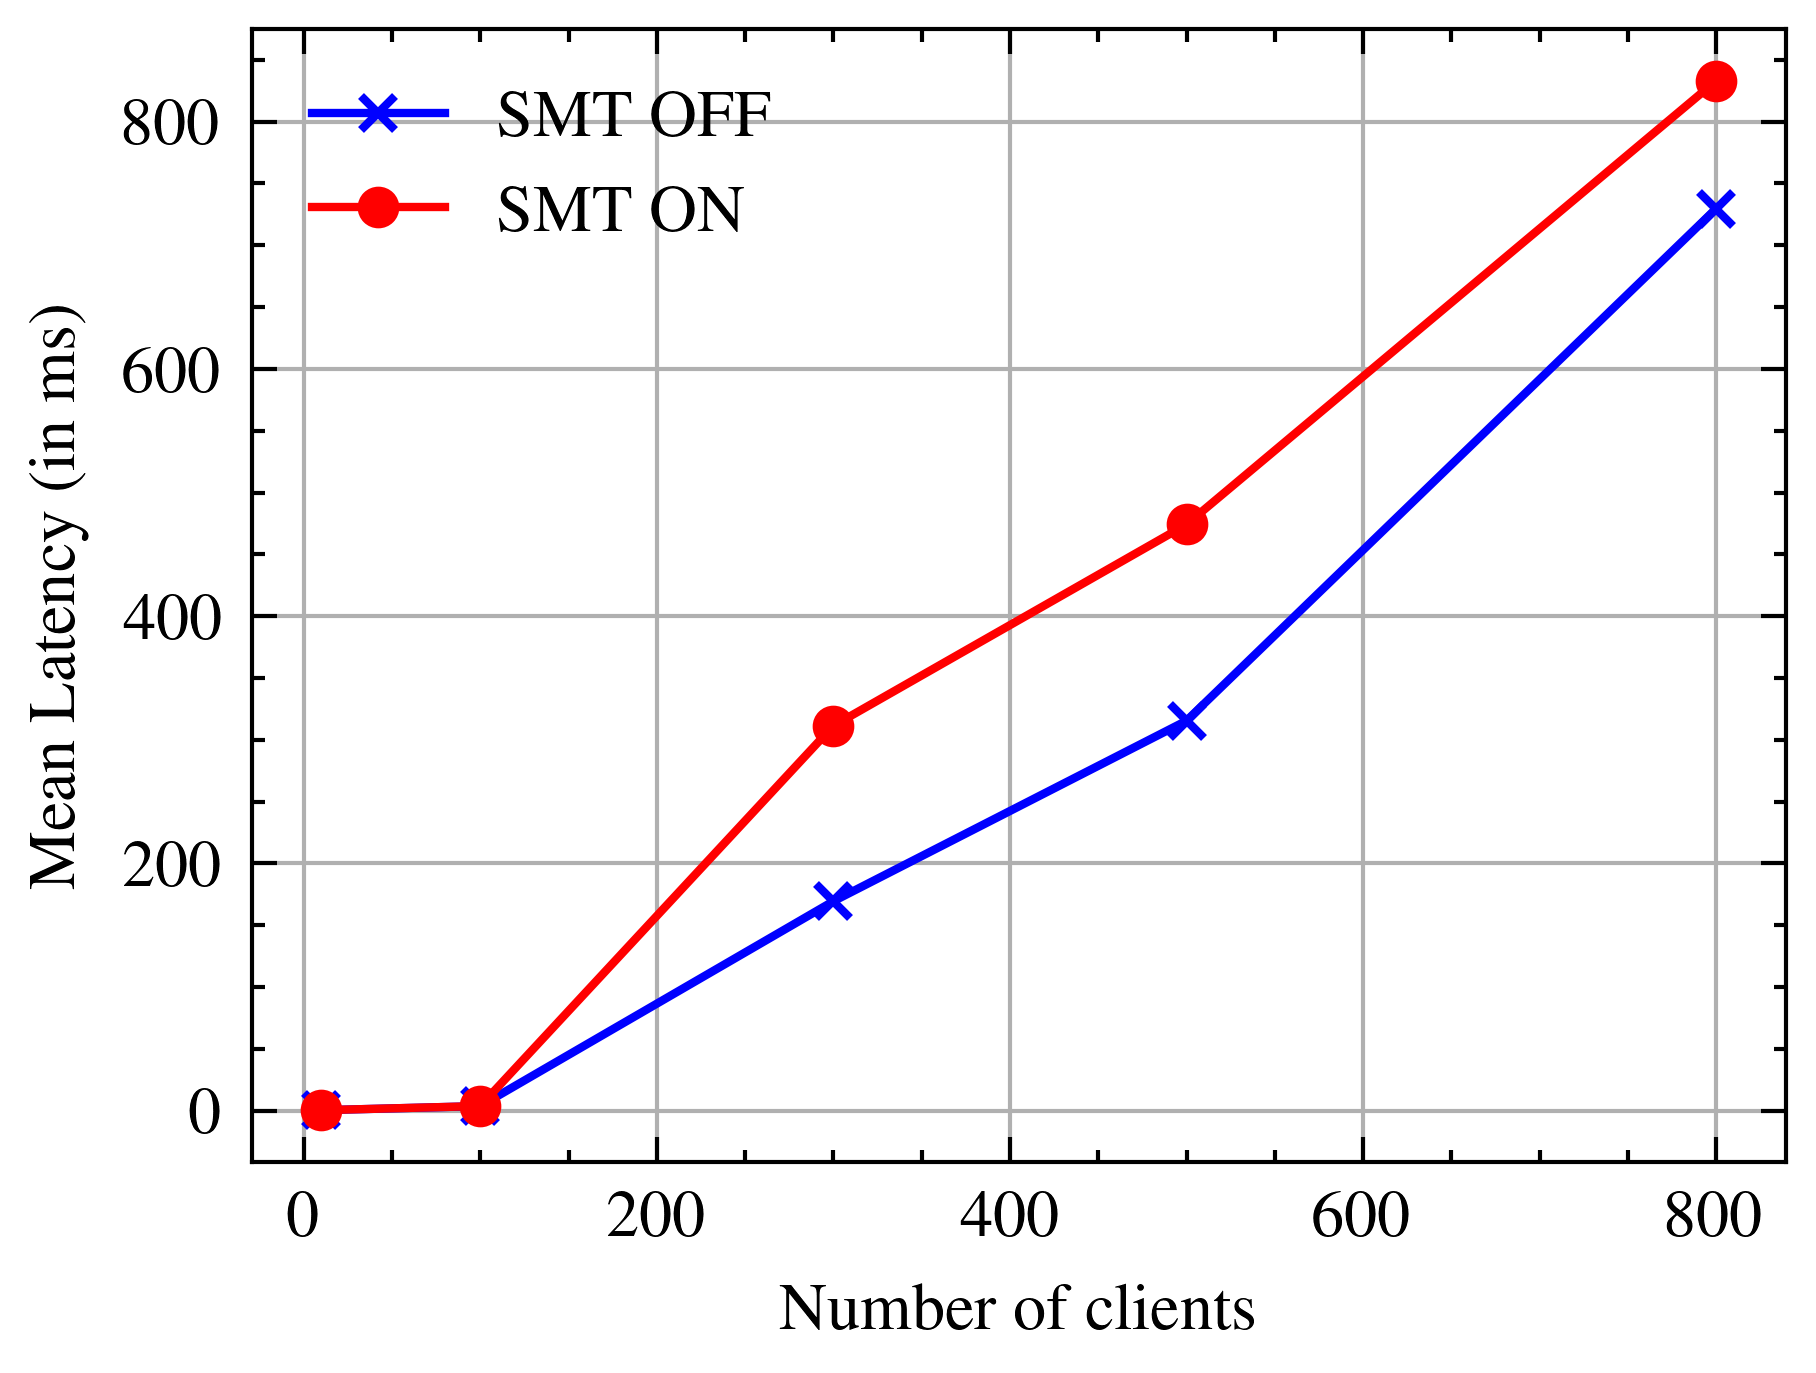

In [109]:
ax = latency_df_18.plot(
    x='client', y='mean',
    style='-', c='blue', marker='x', ms=4, 
    label='SMT OFF')
latency_df_36.plot(
    ax=ax, x='client', y='mean', 
    style='-', c='red', marker='o', ms=4, 
    label='SMT ON', grid=True,
    xlabel="Number of clients", ylabel="Mean Latency (in ms)"
)

<AxesSubplot: xlabel='Number of clients', ylabel='99th perc. Latency (in ms)'>

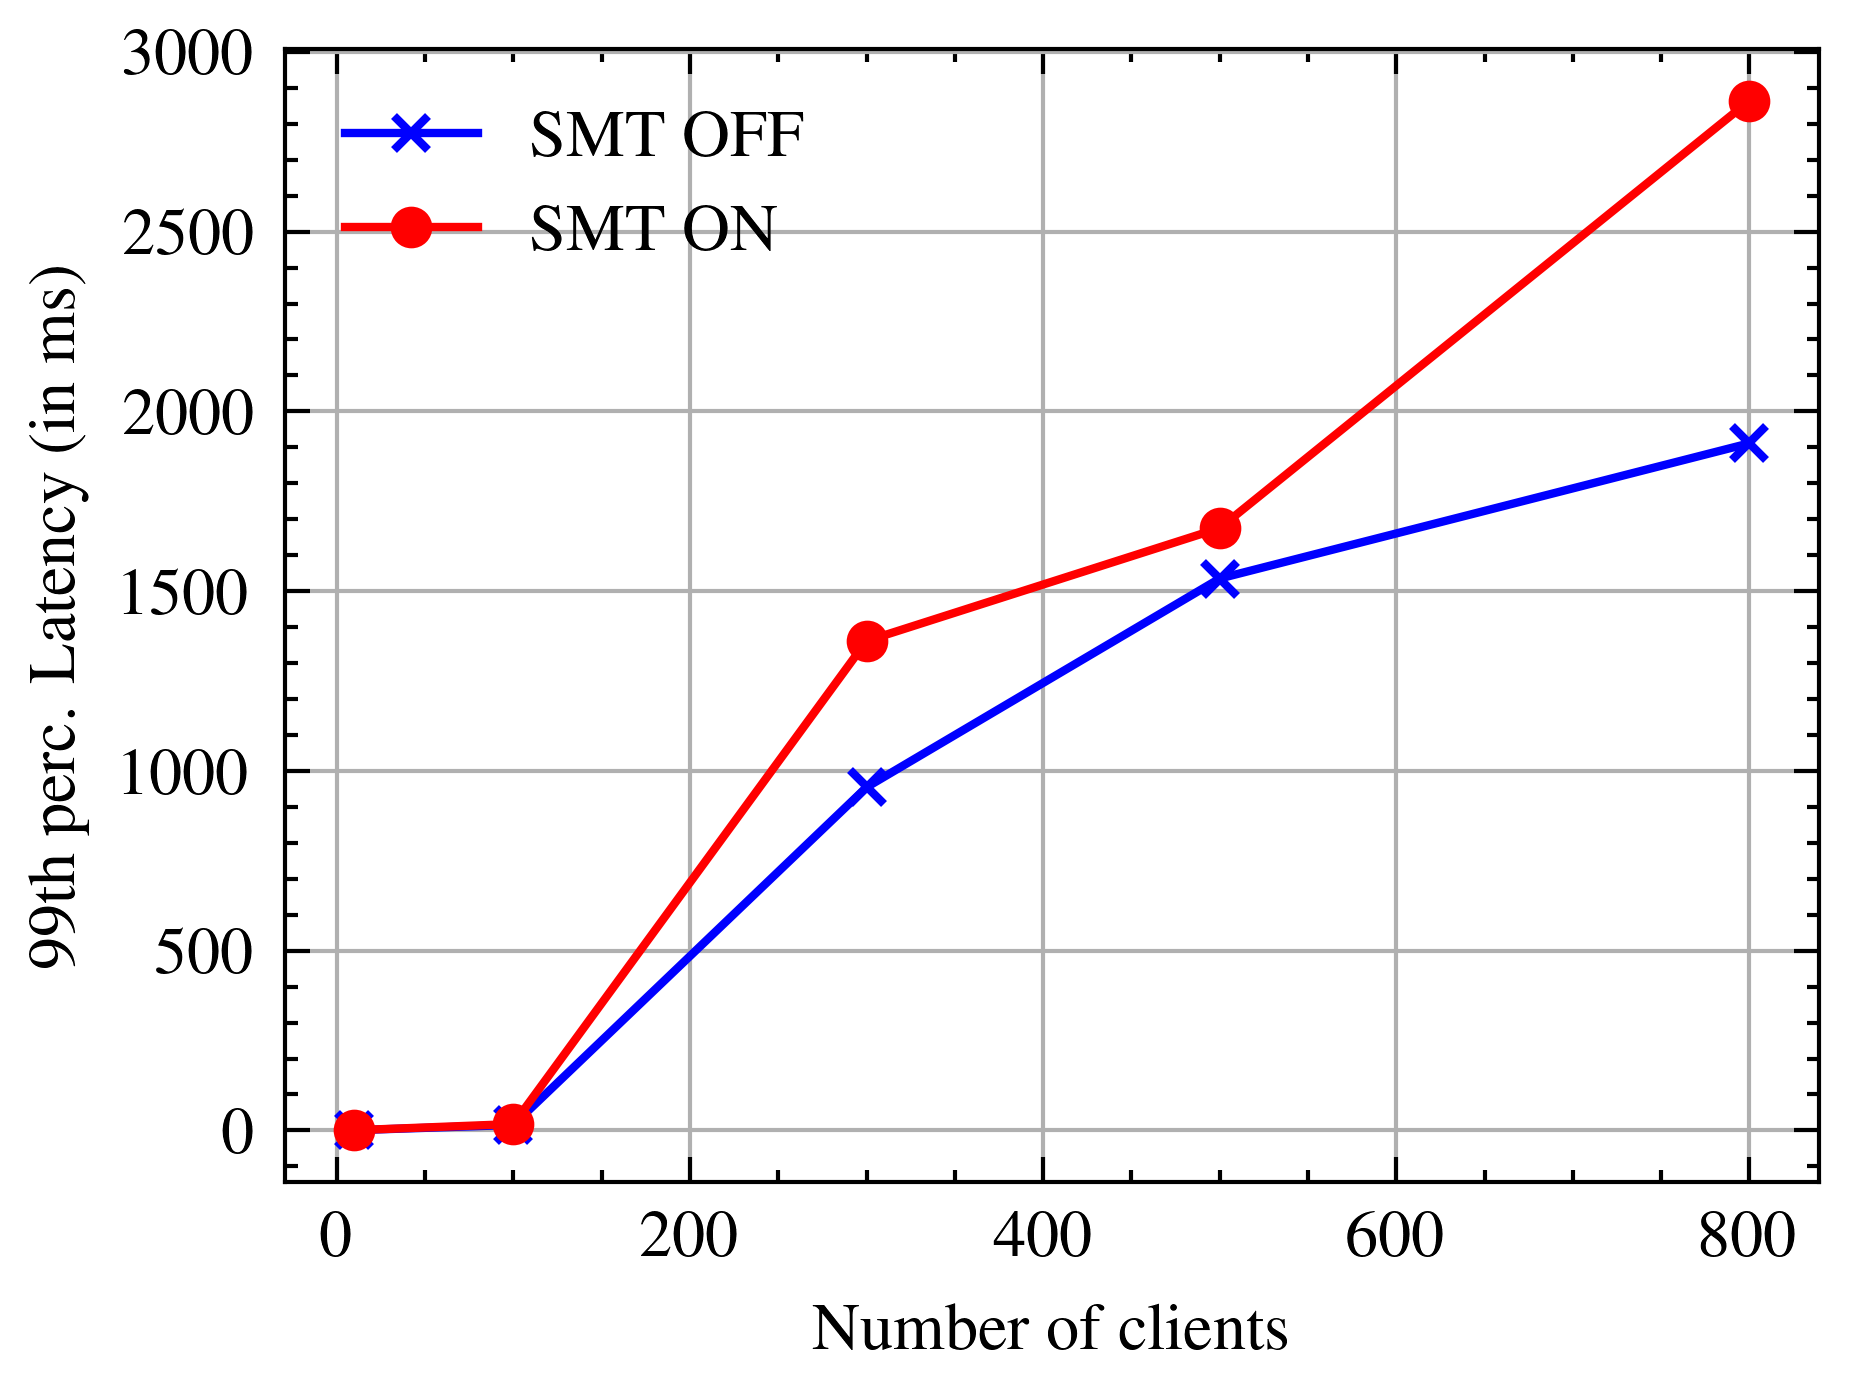

In [110]:
ax = latency_df_18.plot(
    x='client', y='99th',
    style='-', c='blue', marker='x', ms=4, 
    label='SMT OFF')
latency_df_36.plot(
    ax=ax, x='client', y='99th', 
    style='-', c='red', marker='o', ms=4, 
    label='SMT ON', grid=True,
    xlabel="Number of clients", ylabel="99th perc. Latency (in ms)"
)

In [111]:
df_t = []
for i in range(1, 11):
    net_client_csv = pd.read_csv(
        f"../{res_dir}/summary/clients/throughput-{i}.csv",
    )

    net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
    net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
    net_df_avg = net_df.groupby(['cpu', 'client']).mean().reset_index()
    net_df_sum['throughput'] *= 1e-3
    net_df_sum['node'] = i
    df_t.append(net_df_sum)

In [112]:
df = pd.concat(df_t, axis=0)

In [113]:
net_wg = df.groupby(['cpu', 'client']).sum().reset_index()

<AxesSubplot: xlabel='Number of clients', ylabel='Goodput (Gbps)'>

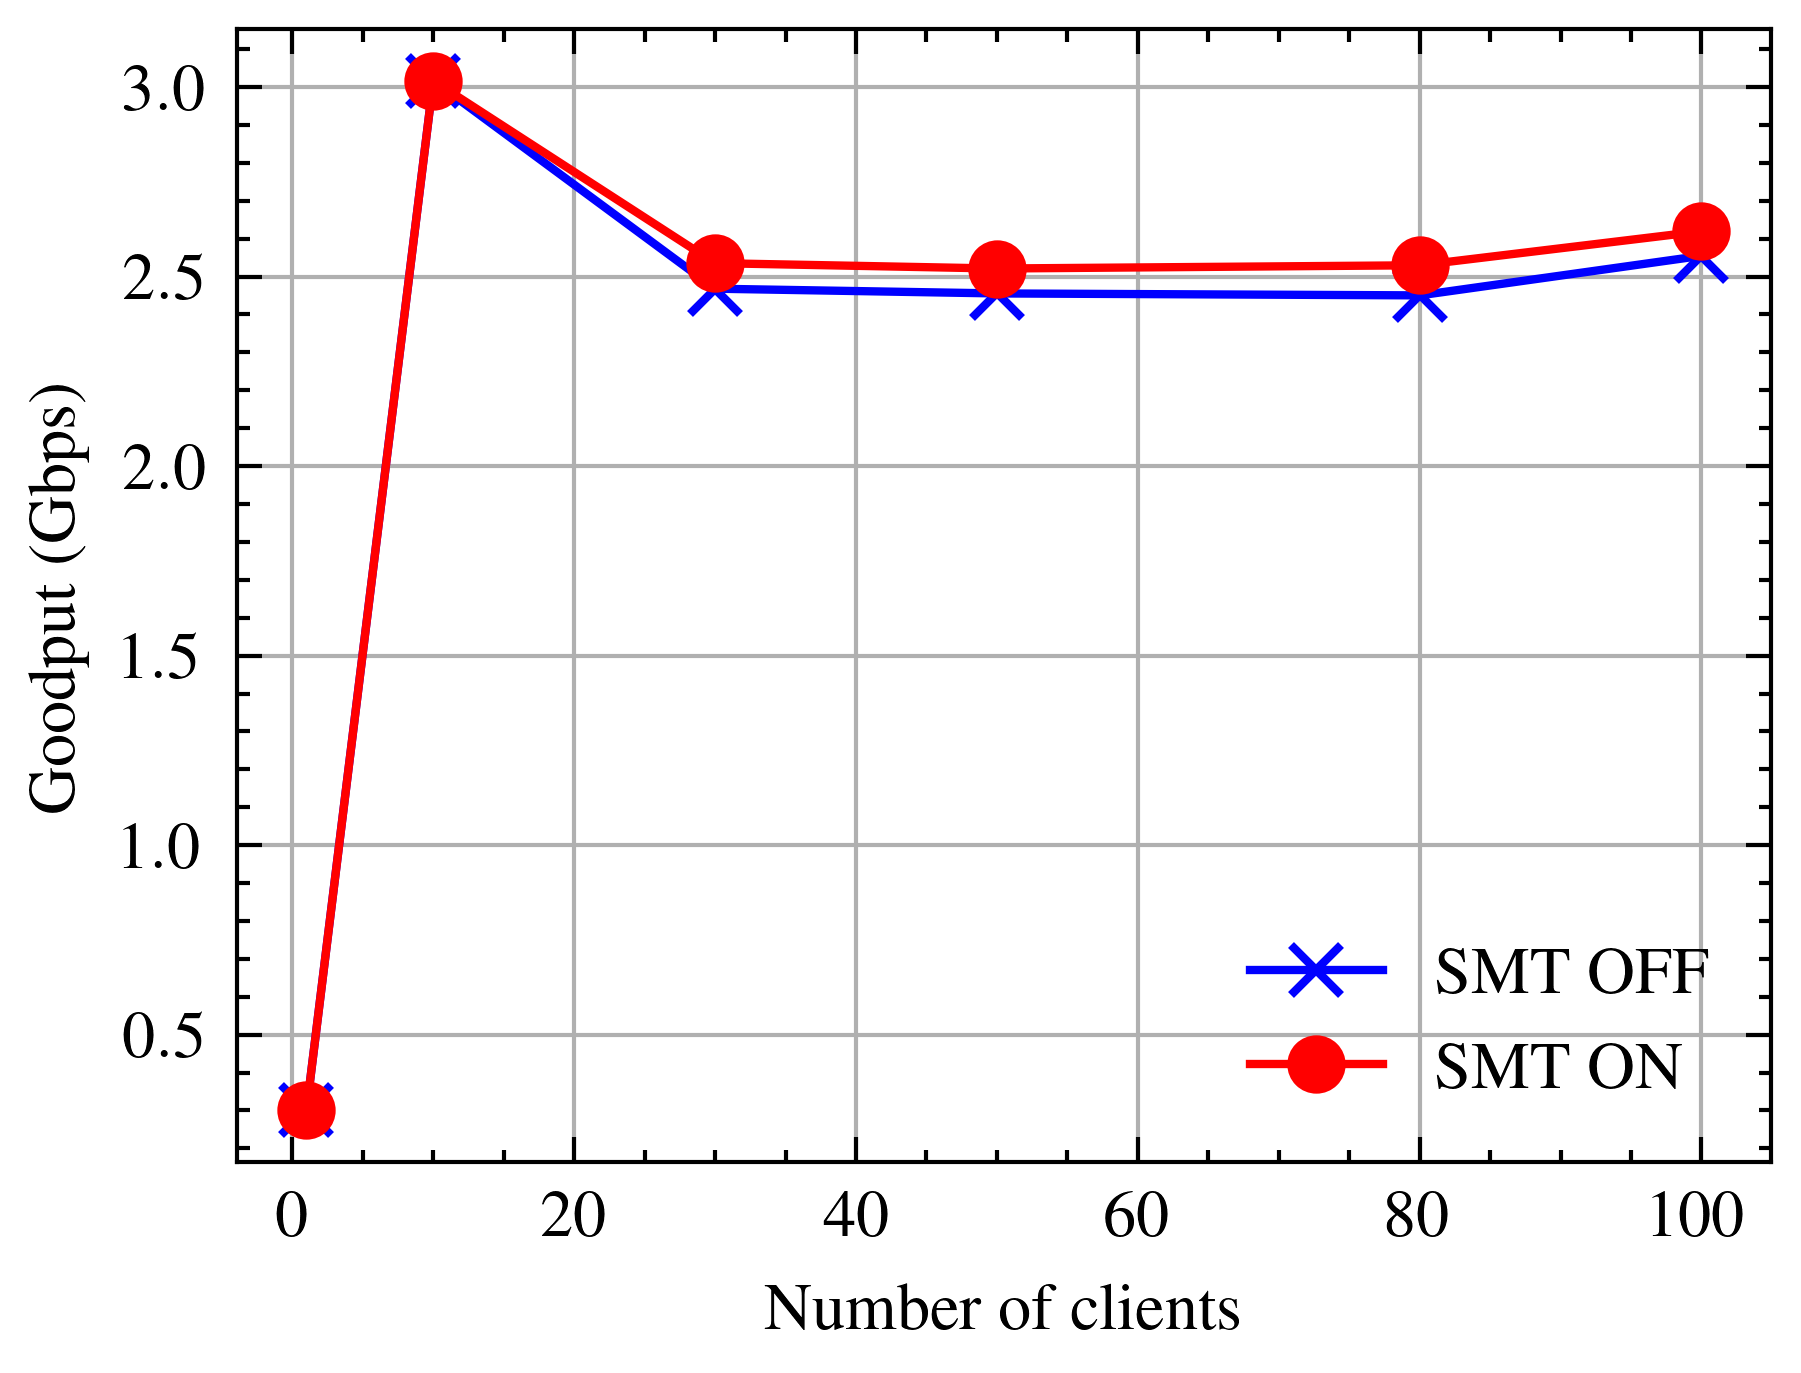

In [114]:
net_wg_18 = net_wg[net_wg.cpu == 18]
net_wg_36 = net_wg[net_wg.cpu == 36]
ax = net_wg_18.plot(
    x='client', y='throughput', 
    xlabel='Number of clients', ylabel='Goodput',
    label='SMT OFF', 
    c='blue', style='-', marker='x',)
net_wg_36.plot(ax=ax, 
    x='client', y='throughput', 
    xlabel='Number of clients', ylabel='Goodput (Gbps)',
    label="SMT ON",
    c='red', style='-', marker='o',
    grid=True)